# What is the most optimal skill to learn for Data Analysts?

Methodology:
1. Group skills to determine median salary and liklihood of being in a posting
2. Visualise median salary vs liklihood skill demand
3. Determine if certain technologies are more pravalent

In [68]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
import ast

# Load Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Clean Up
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda string_list: ast.literal_eval(string_list) if pd.notna(string_list) else string_list)

In [69]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].dropna(subset=['salary_year_avg'])
df_DA_US.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
109,Data Analyst,Senior Supply Chain Analytics Analyst,Anywhere,via Get.It,Full-time,True,"Illinois, United States",2023-10-12 13:02:19,False,True,United States,year,89000.0,NaN,Get It Recruit - Transportation,"[python, r, alteryx, tableau]","{'analyst_tools': ['alteryx', 'tableau'], 'pro..."
180,Data Analyst,Data Analyst III,"Dos Palos, CA",via My ArkLaMiss Jobs,Full-time,False,"California, United States",2023-02-27 13:00:39,False,True,United States,year,90250.0,NaN,California Health & Wellness,"[excel, powerpoint]","{'analyst_tools': ['excel', 'powerpoint']}"
410,Data Analyst,IT Business Lead Data Analyst - VP - Hybrid,"Atlantic Beach, FL",via ComputerJobs.com,Full-time,False,Georgia,2023-01-10 13:59:02,False,False,United States,year,133285.0,NaN,Citi,"[sql, word, excel, visio, powerpoint, sharepoint]","{'analyst_tools': ['word', 'excel', 'visio', '..."
988,Data Analyst,DATA ANALYST (ONSITE),"Springfield, MA",via Indeed,Full-time,False,"New York, United States",2023-11-21 13:00:13,False,False,United States,year,62623.0,NaN,Springfield Public Schools,"[sql, excel, tableau]","{'analyst_tools': ['excel', 'tableau'], 'progr..."
1413,Data Analyst,Junior BI Developer,"Atlanta, GA",via Ai-Jobs.net,Full-time,False,Georgia,2023-10-31 13:57:41,False,True,United States,year,71300.0,NaN,Guidehouse,"[sql, excel, power bi]","{'analyst_tools': ['excel', 'power bi'], 'prog..."


In [70]:
df_exploded = df_DA_US.explode('job_skills').dropna(subset=['job_skills'])

In [71]:
df_skills = df_exploded.groupby('job_skills').agg(
    median_salary=('salary_year_avg', 'median'),
    skill_count=('job_skills', 'count'))

In [72]:
df_skills['skill_percentage'] = (df_skills['skill_count'] / len(df_DA_US)) * 100

In [73]:
df_skills.sort_values(by='skill_percentage', ascending=False, inplace=True)    
df_skills.head(10)

,median_salary,skill_count,skill_percentage
job_skills,,,
sql,91000.00,2508,57.655172
excel,84392.00,1808,41.563218
python,97500.00,1431,32.896552
tableau,92875.00,1364,31.356322
sas,90000.00,926,21.287356
r,92500.00,893,20.528736
power bi,90000.00,838,19.264368
powerpoint,85000.00,462,10.620690
word,81194.75,461,10.597701


In [79]:
skill_percent = 5

df_plot = df_skills[df_skills['skill_percentage'] >= skill_percent]
df_plot.head()

,median_salary,skill_count,skill_percentage
job_skills,,,
sql,91000.0,2508,57.655172
excel,84392.0,1808,41.563218
python,97500.0,1431,32.896552
tableau,92875.0,1364,31.356322
sas,90000.0,926,21.287356


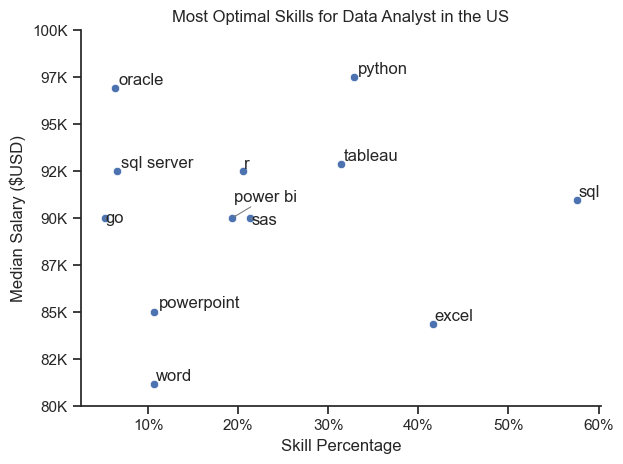

In [75]:
sns.set_theme(style="ticks")

sns.scatterplot(data=df_plot, x='skill_percentage', y='median_salary')
plt.title('Most Optimal Skills for Data Analyst in the US')
plt.xlabel('Skill Percentage')
plt.ylabel('Median Salary ($USD)')

plt.ylim(80000, 100000)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1000)}K'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

texts = []
for i, row in enumerate(df_plot.index):
    if row == 'sas':
        texts.append(plt.text(df_plot['skill_percentage'].iloc[i], df_plot['median_salary'].iloc[i] - 0.1, row))
    else:
        texts.append(plt.text(df_plot['skill_percentage'].iloc[i], df_plot['median_salary'].iloc[i], row))


from adjustText import adjust_text
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.8))


sns.despine()
plt.tight_layout()
plt.show()

In [76]:
technology_dict = {}
df_technology = df['job_type_skills'].copy()

df_technology.drop_duplicates(inplace=True)
df_technology.dropna(inplace=True)

# Combine alldictionaries into one
for row in df_technology:
    row = ast.literal_eval(row)
    for key, value in row.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [80]:
technology_dict.keys()
df_technology =pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])
df_technology = df_technology.explode('skills').set_index('skills', drop=True)

df_plot = df_plot.merge(df_technology, left_index=True, right_index=True, how='left')
df_plot = df_plot[~df_plot.index.duplicated(keep='last')]
df_plot

,median_salary,skill_count,skill_percentage,technology
job_skills,,,,
sql,91000.00,2508,57.655172,programming
excel,84392.00,1808,41.563218,analyst_tools
python,97500.00,1431,32.896552,programming
tableau,92875.00,1364,31.356322,analyst_tools
sas,90000.00,926,21.287356,programming
r,92500.00,893,20.528736,programming
power bi,90000.00,838,19.264368,analyst_tools
powerpoint,85000.00,462,10.620690,analyst_tools
word,81194.75,461,10.597701,analyst_tools


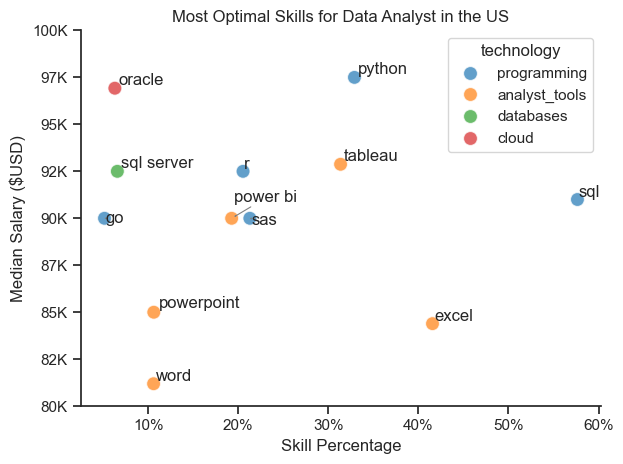

In [81]:
sns.set_theme(style="ticks")

sns.scatterplot(data=df_plot, x='skill_percentage', y='median_salary', hue='technology', palette='tab10', s=100, alpha=0.7)
plt.title('Most Optimal Skills for Data Analyst in the US')
plt.xlabel('Skill Percentage')
plt.ylabel('Median Salary ($USD)')

plt.ylim(80000, 100000)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1000)}K'))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

texts = []
for i, row in enumerate(df_plot.index):
    if row == 'sas':
       texts.append(plt.text(df_plot['skill_percentage'].iloc[i], df_plot['median_salary'].iloc[i] - 0.2, row))
    else:
       texts.append(plt.text(df_plot['skill_percentage'].iloc[i], df_plot['median_salary'].iloc[i], row))


from adjustText import adjust_text
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.8))


sns.despine()
plt.tight_layout()
plt.show()